In [1]:
# import statements
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

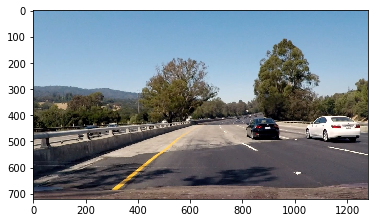

In [2]:
test_images = glob.glob('test_images/*')
image_num = 3
img = mpimg.imread(test_images[image_num])
plt.imshow(img)

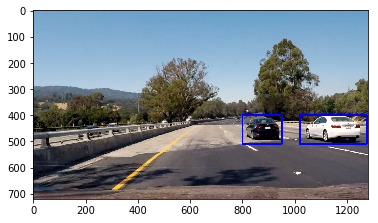

In [3]:
# draw boxes after corners are detected
# boxes argument is an array of tuples, one for each box to draw, 2 corners in each box
# boxes = [((corner1), (corner2)), ((corner1), (corner2)), ((corner1), (corner2))]
# corners = (x,y)
def draw_boxes(img, boxes, color=(0,0,255), thick=6):
    # make copy of image
    draw_image = np.copy(img)
    # draw each box in boxes list
    for box in boxes:
        cv2.rectangle(draw_image, box[0], box[1], color, thick)
    
    return draw_image

# sample boxes for test image index 3
boxes = [((800,400),(950, 510)), ((1020,400),(1275,510))]

plt.imshow(draw_boxes(img, boxes))

# Template matching

+ Highly dependent on finding exact matches
+ Differences that occur frame to frame such as lighting, size, and orientation cause it to fail miserably

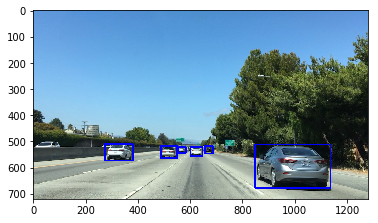

In [17]:
## test template matching
## 
template_images = glob.glob('cutouts/*')
img = mpimg.imread(template_images[0])
templates = template_images[1:]

def match_template(img, templates):
    # define empty boxes list
    bboxes_list = []
    
    for template_path in templates:
        # read in template image
        template_img = mpimg.imread(template_path)
        # find best match using squared difference
        result = cv2.matchTemplate(img, template_img, method=cv2.TM_SQDIFF)
        # locate min and max locations
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # set bounding box sizes based on template shape
        w,h = template_img.shape[1], template_img.shape[0]
        # define coordinates using min or max location
        top_left = min_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # append coordinates of boxes to bboxes_list
        bboxes_list.append((top_left, bottom_right))
        
    return bboxes_list

boxes = match_template(img, templates)
drawn_img = draw_boxes(img, boxes)
plt.imshow(drawn_img)

+ Using color histograms allows us to look for distributions of colors which are very similar frame to frame
+ Could fail if there are other objects of a similar color: red smart car, red stop sign, red billboard

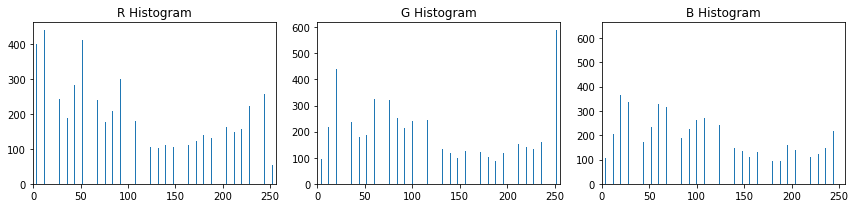

In [42]:
template_images = glob.glob('cutouts/*')
img = mpimg.imread(template_images[0])
templates = template_images[1:]
temp_img = mpimg.imread(templates[0])

# find histograms of each color channel
def color_hist(img, nbins=32, bins_range=(0,256)):
    # find histograms of each color channel
    rhist = np.histogram(img[:,:,0], nbins, bins_range)
    ghist = np.histogram(img[:,:,1], nbins, bins_range)
    bhist = np.histogram(img[:,:,2], nbins, bins_range)
    
    # concatenate into single feature vector
    feature_vector = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    # calculate bin centers based on nbins and bins_range parameters
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[:len(bin_edges)-1]) / 2
    return rhist, ghist, bhist, bin_centers, feature_vector

rhist, ghist, bhist, bin_centers, feature_vector = color_hist(temp_img)


## plot individual histograms ##
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram')
fig.tight_layout()

# Exploring colorspaces using 3D plot

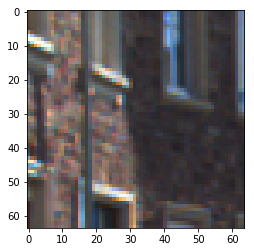

In [65]:
colorspace_cutouts = glob.glob('colorspace_cutouts/*')
cars = colorspace_cutouts[:3]
background = colorspace_cutouts[3:]
cutout = mpimg.imread(background[2])
plt.imshow(cutout)

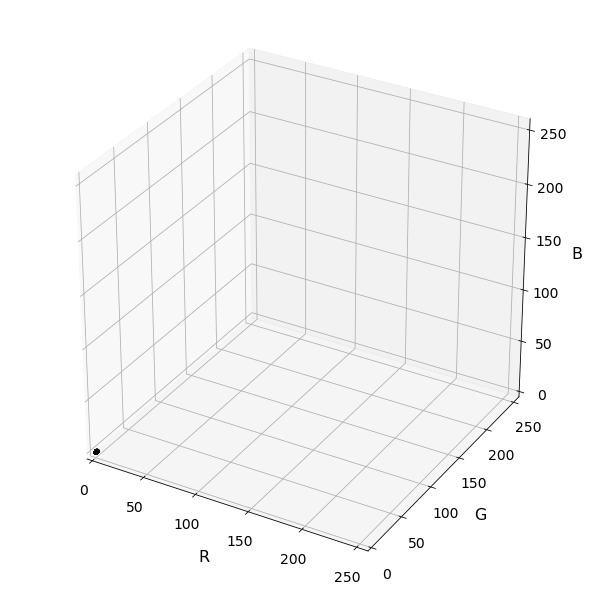

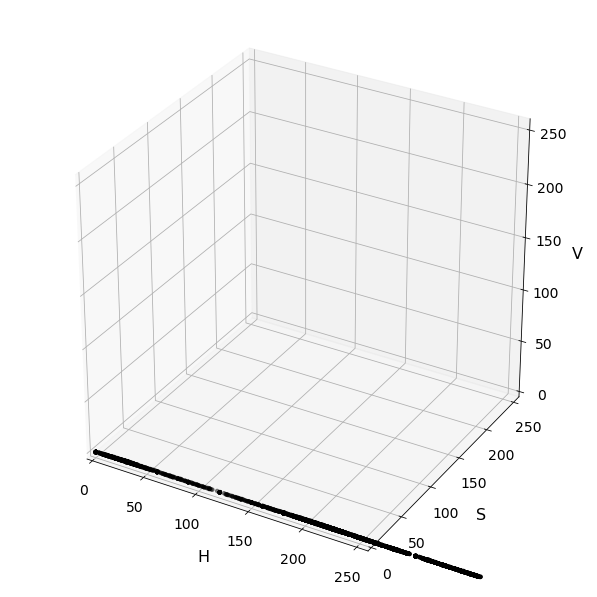

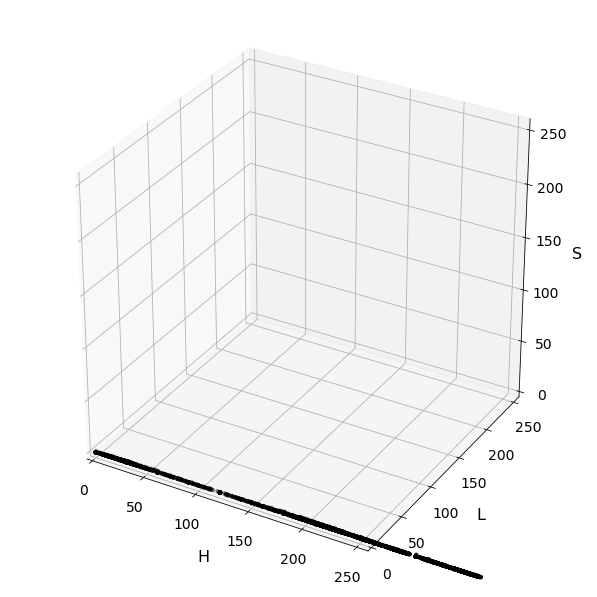

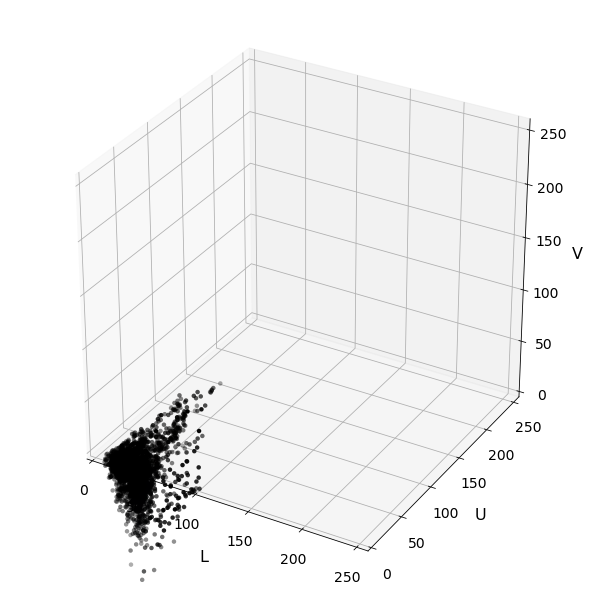

In [66]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cutout

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
plt.show()

plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plt.show()